In [ ]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import random
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import models
import torchvision.transforms as transforms
import torch.optim as optim
from skimage import io
import torch.nn.functional as F
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from sklearn.utils import shuffle

# Data preparation

In [ ]:
train_dir='/kaggle/input/labeled-chest-xray-images/chest_xray/train'
test_dir='/kaggle/input/labeled-chest-xray-images/chest_xray/test'

In [ ]:
# labeling the images into 3 classes instead of 2
# labels: 0-normal, 1-virus, 2-bacteria

train_labels={"filename":[], "label":[], "type":[], "binary class":[]}
test_labels={"filename":[], "label":[], "type":[], "binary class":[]}

for img_name in os.listdir(train_dir+"/NORMAL"):
    train_labels["filename"].append(img_name)
    train_labels["label"].append(0)
    train_labels["type"].append("normal")
    train_labels["binary class"].append("NORMAL")

for img_name in os.listdir(test_dir+"/NORMAL"):
    test_labels["filename"].append(img_name)
    test_labels["label"].append(0)
    test_labels["type"].append("normal")
    test_labels["binary class"].append("NORMAL")

for img_name in os.listdir(train_dir+"/PNEUMONIA"):
    if img_name[:1]=="V":
        train_labels["filename"].append(img_name)
        train_labels["label"].append(1)
        train_labels["type"].append("virus")
        train_labels["binary class"].append("PNEUMONIA")
    else:
        train_labels["filename"].append(img_name)
        train_labels["label"].append(2)
        train_labels["type"].append("bacteria")
        train_labels["binary class"].append("PNEUMONIA")

for img_name in os.listdir(test_dir+"/PNEUMONIA"):
    if img_name[:1]=="V":
        test_labels["filename"].append(img_name)
        test_labels["label"].append(1)
        test_labels["type"].append("virus")
        test_labels["binary class"].append("PNEUMONIA")
    else:
        test_labels["filename"].append(img_name)
        test_labels["label"].append(2)
        test_labels["type"].append("bacteria")
        test_labels["binary class"].append("PNEUMONIA")


train_data=pd.DataFrame.from_dict(train_labels)
train_data =train_data.assign(img_path=lambda x: train_dir +"/"+ x['binary class'] +"/"+ x['filename'])
#train_data.drop(labels=["binary class"], axis=1, inplace=True)

df_bacteria = train_data[train_data['type'] == 'bacteria']
df_normal = train_data[train_data['type'] == 'normal']
df_virus = train_data[train_data['type'] == 'virus']
target_size = min(len(df_normal), len(df_virus))
df_bacteria_downsampled = df_bacteria.sample(n=target_size, random_state=42)
train_data = pd.concat([df_bacteria_downsampled, df_normal, df_virus])
train_data = shuffle(train_data, random_state=42)

train_data.to_csv("train_labels.csv", index=False)

test_data=pd.DataFrame.from_dict(test_labels)
test_data =test_data.assign(img_path=lambda x: test_dir +"/"+ x['binary class'] +"/"+ x['filename'])
#test_data.drop(labels=["binary class"], axis=1, inplace=True)

df_bacteria_t = test_data[test_data['type'] == 'bacteria']
df_normal_t = test_data[test_data['type'] == 'normal']
df_virus_t = test_data[test_data['type'] == 'virus']
target_size_t = min(len(df_normal_t), len(df_virus_t))
df_bacteria_downsampled_t = df_bacteria_t.sample(n=target_size_t, random_state=42)
test_data = pd.concat([df_bacteria_downsampled_t, df_normal_t, df_virus_t])
test_data = shuffle(test_data, random_state=42)

test_data.to_csv("test_labels.csv", index=False)

In [ ]:
train_data

,filename,label,type,binary class,img_path
2623,VIRUS-2965742-0002.jpeg,1,virus,PNEUMONIA,/kaggle/input/labeled-chest-xray-images/chest_...
2029,BACTERIA-6684872-0001.jpeg,2,bacteria,PNEUMONIA,/kaggle/input/labeled-chest-xray-images/chest_...
678,NORMAL-4688588-0001.jpeg,0,normal,NORMAL,/kaggle/input/labeled-chest-xray-images/chest_...
1101,NORMAL-7061098-0001.jpeg,0,normal,NORMAL,/kaggle/input/labeled-chest-xray-images/chest_...
2811,VIRUS-9197445-0002.jpeg,1,virus,PNEUMONIA,/kaggle/input/labeled-chest-xray-images/chest_...
...,...,...,...,...,...
3956,BACTERIA-8308763-0001.jpeg,2,bacteria,PNEUMONIA,/kaggle/input/labeled-chest-xray-images/chest_...
3267,BACTERIA-5839760-0003.jpeg,2,bacteria,PNEUMONIA,/kaggle/input/labeled-chest-xray-images/chest_...
1777,BACTERIA-7172433-0005.jpeg,2,bacteria,PNEUMONIA,/kaggle/input/labeled-chest-xray-images/chest_...
3659,VIRUS-8498536-0002.jpeg,1,virus,PNEUMONIA,/kaggle/input/labeled-chest-xray-images/chest_...


In [ ]:
label_count=train_data.groupby(by="type", as_index=False).count().sort_values(by="filename", ascending=False).reset_index(drop=True)
label_count_test=test_data.groupby(by="type", as_index=False).count().sort_values(by="filename", ascending=False).reset_index(drop=True)
print("Label distribution is train data: \n", label_count[["type", "filename"]], "\n")
print("Label distribution is test data: \n", label_count_test[["type", "filename"]])

Label distribution is train data: 
        type  filename
0    normal      1349
1  bacteria      1345
2     virus      1345 

Label distribution is test data: 
        type  filename
0    normal       234
1  bacteria       148
2     virus       148


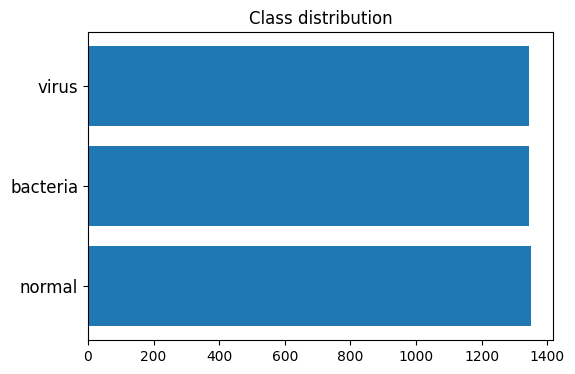

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
ax=plt.barh(label_count["type"], label_count["filename"])
plt.title("Class distribution")
plt.xticks(fontsize = 10)
plt.yticks(["bacteria", "normal", "virus"], fontsize = 12)
plt.show()

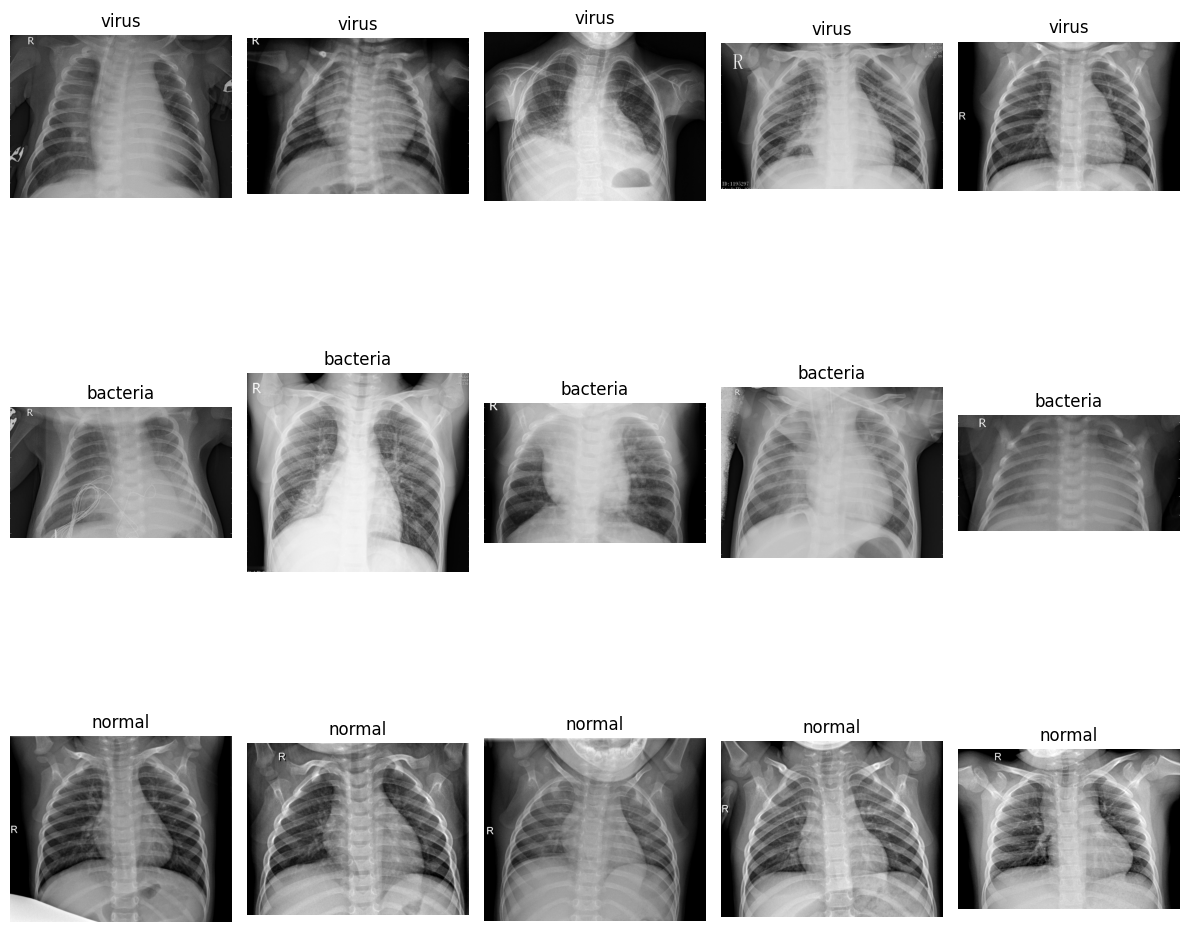

In [ ]:
types = train_data['type'].unique()
num_types = len(types)
num_images_per_type = 5

fig, axes = plt.subplots(num_types, num_images_per_type, figsize=(12, 4 * num_types))

for i, type_ in enumerate(types):
    subset = train_data[train_data['type'] == type_].head(num_images_per_type)

    for j, (idx, row) in enumerate(subset.iterrows()):
        img_path = row['img_path']

        img = mpimg.imread(img_path)
        axes[i, j].imshow(img, cmap="gray")
        axes[i, j].set_title(f"{row['type']}")
        axes[i, j].axis('off')

        #print(img.size)

plt.tight_layout()
plt.show()

# Dataset classes

In [ ]:
class Train_dataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        img_path=self.data.iloc[index, 4]
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.data.iloc[index, 1]))


        if self.transform:
            image = self.transform(image)
        return (image, y_label)

In [ ]:
class Test_dataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.transform = transform
        self.data=pd.read_csv(csv_file)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        img_path=self.data.iloc[index, 4]
        image = io.imread(img_path)

        if self.transform:
            image = self.transform(image)

        return image

In [ ]:
train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Grayscale(3),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])
test_transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Grayscale(3),
                                transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                    [0.229, 0.224, 0.225])])


In [ ]:
num_classes = 3
learning_rate = 0.001
batch_size = 64
num_epochs = 20
lr_ratio=0.005
weight_decay = 1e-4

In [ ]:
dataset = Train_dataset('/kaggle/working/train_labels.csv', transform=train_transform)
train_set_size = int(len(dataset) * 0.8)
print("Train set length: ", train_set_size)
valid_set_size = len(dataset) - train_set_size
print("Validation set length: ", valid_set_size)
train_set, valid_set = torch.utils.data.random_split(dataset, [train_set_size, valid_set_size])
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_set, batch_size=batch_size, shuffle=True)

test_data = Test_dataset('/kaggle/working/test_labels.csv', transform=test_transform)
print("Test set length: ",len(test_data))
test_loader = DataLoader(test_data, batch_size=batch_size)

Train set length:  3231
Validation set length:  808
Test set length:  530


# Functions for training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device")
print(device)

Device
cuda


In [ ]:
# save checkpoint
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    torch.save(state, filename)

# load checkpint
def load_checkpoint(checkpoint, model, optimizer):
    print("Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    #scheduler = checkpoint['scheduler']

In [ ]:
def plot_results(training_accuracy_list, training_loss_list, validation_accuracy_list, validation_loss_list, name):
    epochs = len(training_accuracy_list)
    x = np.arange(1, epochs + 1)

    training_accuracy_list = [item.cpu().numpy() if isinstance(item, torch.Tensor) else item for item in training_accuracy_list]
    training_loss_list = [item.cpu().numpy() if isinstance(item, torch.Tensor) else item for item in training_loss_list]
    validation_accuracy_list = [item.cpu().numpy() if isinstance(item, torch.Tensor) else item for item in validation_accuracy_list]
    best_loss_list = [item.cpu().numpy() if isinstance(item, torch.Tensor) else item for item in validation_loss_list]

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].plot(x, training_accuracy_list, label='Training Accuracy', color='blue')
    axes[1].plot(x, training_loss_list, label='Training Loss', color='orange')
    axes[0].plot(x, validation_accuracy_list, label='Validation Accuracy', color='green')
    axes[1].plot(x, best_loss_list, label='Validation Loss', color='red')

    fig.suptitle('Model Evaluation Metrics')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()
    axes[0].grid(True)
    axes[1].set_xlabel('Epochs')
    axes[1].legend()
    axes[1].grid(True)

    plt.savefig(f"{name}.png")

    plt.show()

In [ ]:
def validation(model, device, valid_loader, loss_function):

    model.eval()
    loss_total = 0
    correct = 0

    with torch.no_grad():
        for data in valid_loader:
            input = data[0].to(device)
            label = data[1].to(device)
            output = model(input)
            _, predicted = output.max(1)
            loss = loss_function(output, label)
            loss_total += loss.item()
            correct+= (predicted == label).sum()
        validation_accuracy = correct/len(valid_loader.sampler)
    return loss_total / len(valid_loader), validation_accuracy

In [ ]:
def traindata(device, model, epochs, optimizer, scheduler, loss_function, train_loader, valid_loader, filename):
    # Early stopping
    best_loss = 100
    patience = 5
    trigger_times = 0

    # Lists to store data for plotting
    training_accuracy_list = []
    training_loss_list = []
    best_loss_list = []
    validation_accuracy_list = []
    validation_loss_list = []

    for epoch in range(1, epochs+1):
        model.train()
        correct = 0
        loss_total = 0
        for data in train_loader:
            input = data[0].to(device)
            label = data[1].to(device)

            optimizer.zero_grad()

            output = model(input)
            _, predicted = output.max(1)
            loss = loss_function(output, label)
            loss_total += loss.item()
            correct+= (predicted == label).sum()
            loss.backward()
            optimizer.step()
            scheduler.step()

        training_accuracy = correct/len(train_loader.sampler)
        training_loss = loss_total/len(train_loader)

        print('{}. epoch'.format(epoch))


         # Early stopping
        current_loss, validation_accuracy = validation(model, device, valid_loader, loss_function)
        print('Training accuracy: {} Training loss: {} \nValidation accuracy: {} Validation loss: {}'.format(training_accuracy, training_loss, validation_accuracy, current_loss))

        # Append values to lists for plotting
        training_accuracy_list.append(training_accuracy)
        training_loss_list.append(training_loss)
        validation_accuracy_list.append(validation_accuracy)
        validation_loss_list.append(current_loss)
        best_loss_list.append(best_loss)

        if current_loss > best_loss:
            trigger_times += 1

            if trigger_times >= patience:
                print('Early stopping! Start to test process.')
                break
        else:
            trigger_times = 0
            save_checkpoint(checkpoint, filename)
            best_loss = current_loss

    # Plot the results
    plot_results(training_accuracy_list, training_loss_list, validation_accuracy_list, validation_loss_list, filename)

    return model

In [ ]:
def test(device, model, test_loader, loss_function):
    model.eval()
    predictions = pd.DataFrame()
    with torch.no_grad():
        for data in test_loader:
            input = data.to(device)
            output = model(input)
            m = nn.Softmax(dim=1)
            res = m(output)
            predictions = pd.concat([predictions, pd.DataFrame(torch.Tensor.cpu(res).numpy(), columns = [0, 1, 2])], ignore_index=True)
        return (predictions)

# CNNs

## Baseline model

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=50):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



model_simple = SimpleCNN(num_classes=num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_simple = model_simple.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_simple.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=learning_rate * lr_ratio)
checkpoint = {"state_dict": model_simple.state_dict(), "optimizer": optimizer.state_dict(), "scheduler": scheduler}

1. epoch
Training accuracy: 0.5140823721885681 Training loss: 1.688026652616613 
Validation accuracy: 0.6868811845779419 Validation loss: 0.8834044612371005
2. epoch
Training accuracy: 0.7103064656257629 Training loss: 0.7351731739792169 
Validation accuracy: 0.7363861203193665 Validation loss: 0.5901508560547462
3. epoch
Training accuracy: 0.7684927582740784 Training loss: 0.528490860672558 
Validation accuracy: 0.7673267126083374 Validation loss: 0.5402924212125632
4. epoch
Training accuracy: 0.8087279796600342 Training loss: 0.43932413236767637 
Validation accuracy: 0.7772276997566223 Validation loss: 0.4848713003672086
5. epoch
Training accuracy: 0.8276075720787048 Training loss: 0.38726672939225737 
Validation accuracy: 0.8007425665855408 Validation loss: 0.45576010988308835
6. epoch
Training accuracy: 0.8446301817893982 Training loss: 0.38109539157035305 
Validation accuracy: 0.801980197429657 Validation loss: 0.43785376044420093
7. epoch
Training accuracy: 0.872485339641571 Trai

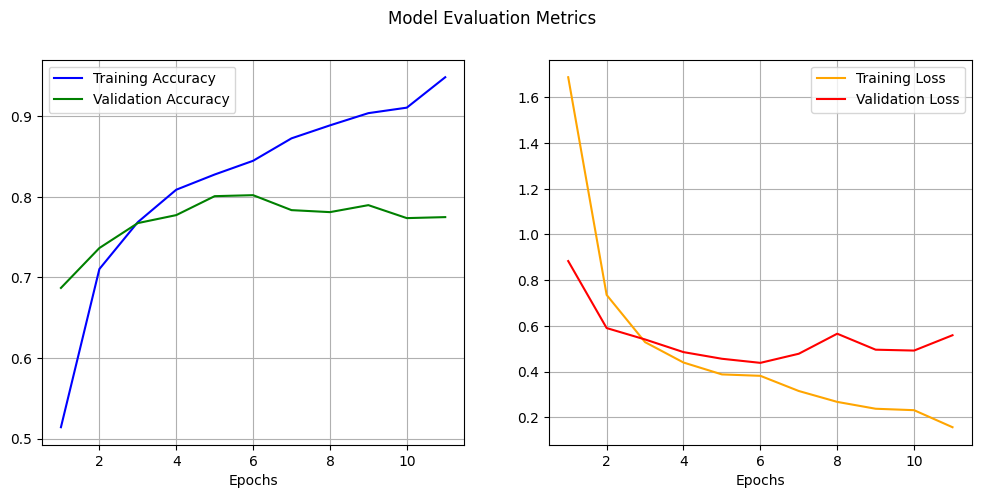

In [ ]:
baseline = traindata(device, model_simple, 1, optimizer, scheduler, criterion, train_loader, valid_loader, "baseline_checkpoint.pth.tar")

In [ ]:
load_checkpoint(torch.load("baseline_checkpoint.pth.tar"), model_simple, optimizer)

Loading checkpoint


/tmp/ipykernel_30/1500998288.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_checkpoint(torch.load("baseline_checkpoint.pth.tar"), model_simple, optimizer)


In [ ]:
df = test(device, baseline, test_loader, criterion)
df=pd.concat([df, pd.DataFrame(test_labels["label"], columns=["true_label"])], axis=1)
df = df.dropna(subset=[0, 1, 2])
df["pred"]=df[[0, 1, 2]].idxmax(axis=1).astype(np.int64)
df.to_csv('baseline.csv', index=False)
df

,0,1,2,true_label,pred
0,0.004540,0.296640,0.698819,0,2
1,0.000645,0.214046,0.785309,0,2
2,0.000129,0.067530,0.932341,0,2
3,0.988064,0.007964,0.003972,0,0
4,0.883015,0.100452,0.016533,0,0
...,...,...,...,...,...
525,0.000558,0.094068,0.905374,1,2
526,0.000740,0.315857,0.683403,1,2
527,0.203959,0.085352,0.710689,2,2
528,0.001505,0.867404,0.131092,1,1


In [ ]:
print("Test accuracy is: ", accuracy_score(df["true_label"], df["pred"]))

Test accuracy is:  0.31886792452830187


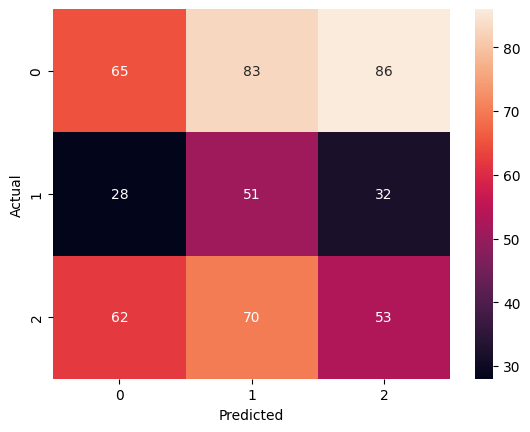

In [ ]:
conf_matrix = confusion_matrix(df["true_label"], df["pred"])
ax=sns.heatmap(conf_matrix, annot=True)
ax.set(xlabel="Predicted", ylabel="Actual")
plt.show()

## Simple CNN

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ExtendedCNN(nn.Module):
    def __init__(self, num_classes=50):
        super(ExtendedCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 7 * 7, 512)  # Adjusted input features
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

        # Dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Convolutional layers with pooling
        x = self.pool(F.relu(self.conv1(x)))  # Output: (16, 112, 112)
        x = self.pool(F.relu(self.conv2(x)))  # Output: (32, 56, 56)
        x = self.pool(F.relu(self.conv3(x)))  # Output: (64, 28, 28)
        x = self.pool(F.relu(self.conv4(x)))  # Output: (128, 14, 14)
        x = self.pool(F.relu(self.conv5(x)))  # Output: (256, 7, 7)

        # Flatten the tensor for fully connected layers
        x = x.view(-1, 256 * 7 * 7)

        # Fully connected layers with ReLU and Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model_cnn = ExtendedCNN(num_classes=num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cnn = model_cnn.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=learning_rate * lr_ratio)
checkpoint = {"state_dict": model_cnn.state_dict(), "optimizer": optimizer.state_dict(), "scheduler": scheduler}

1. epoch
Training accuracy: 0.4289693832397461 Training loss: 1.0454808286592072 
Validation accuracy: 0.6064356565475464 Validation loss: 0.8397755256065955
2. epoch
Training accuracy: 0.6895698308944702 Training loss: 0.6566650341538822 
Validation accuracy: 0.7487623691558838 Validation loss: 0.5602474418970255
3. epoch
Training accuracy: 0.7465181350708008 Training loss: 0.5349421688154632 
Validation accuracy: 0.7363861203193665 Validation loss: 0.5574534764656653
4. epoch
Training accuracy: 0.7672547698020935 Training loss: 0.4819535104667439 
Validation accuracy: 0.7660890817642212 Validation loss: 0.4868441132398752
5. epoch
Training accuracy: 0.7870628833770752 Training loss: 0.460515861417733 
Validation accuracy: 0.771039605140686 Validation loss: 0.5072322304432209
6. epoch
Training accuracy: 0.8065614700317383 Training loss: 0.4189584132503061 
Validation accuracy: 0.7834158539772034 Validation loss: 0.4697519059364612
7. epoch
Training accuracy: 0.8112040162086487 Trainin

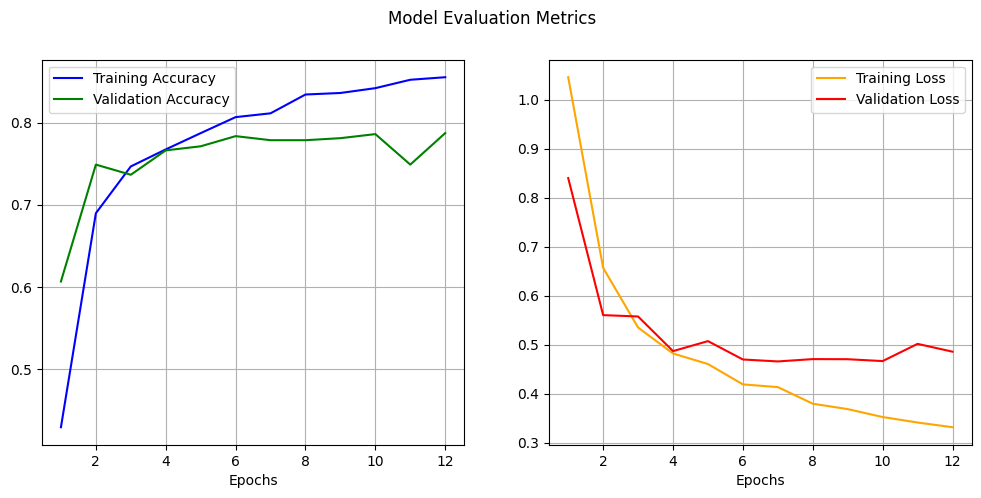

In [ ]:
simplecnn = traindata(device, model_cnn, num_epochs, optimizer, scheduler, criterion, train_loader, valid_loader, "cnn1_checkpoint.pth.tar")

In [ ]:
load_checkpoint(torch.load("/kaggle/input/cnn1-tar-file/cnn1_checkpoint.pth.tar"), simplecnn, optimizer)

Loading checkpoint


/tmp/ipykernel_30/256571438.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_checkpoint(torch.load("/kaggle/input/cnn1-tar-file/cnn1_checkpoint.pth.tar"), simplecnn,

In [ ]:
df = test(device, model_cnn, test_loader, criterion)
df=pd.concat([df, pd.DataFrame(test_labels["label"], columns=["true_label"])], axis=1)
df = df.dropna(subset=[0, 1, 2])
df["pred"]=df[[0, 1, 2]].idxmax(axis=1).astype(np.int64)
df.to_csv('cnn1.csv', index=False)
df

,0,1,2,true_label,pred
0,0.111142,0.332139,0.556719,0,2
1,0.000237,0.296775,0.702988,0,2
2,0.000002,0.060428,0.939570,0,2
3,0.991581,0.004164,0.004255,0,0
4,0.070814,0.607888,0.321298,0,1
...,...,...,...,...,...
525,0.000031,0.149356,0.850613,1,2
526,0.000502,0.206347,0.793151,1,2
527,0.244701,0.174307,0.580992,2,2
528,0.000168,0.697766,0.302065,1,1


In [ ]:
print("Test accuracy is: ", accuracy_score(df["true_label"], df["pred"]))

Test accuracy is:  0.32075471698113206


## Other CNN (not in the documentation)

In [ ]:
class ModifiedCNN(nn.Module):
    def __init__(self, num_classes=50):
        super(ModifiedCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # Output: (32, 224, 224)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Output: (64, 112, 112)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # Output: (128, 56, 56)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)  # Output: (256, 28, 28)

        # Pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Halves spatial dimensions

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 28 * 28, 512)  # Adjusted to match new dimensions
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

        # Dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Convolutional layers with pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Output: (32, 112, 112)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Output: (64, 56, 56)
        x = F.relu(self.bn3(self.conv3(x)))             # Output: (128, 56, 56)
        x = self.pool(F.relu(self.conv4(x)))            # Output: (256, 28, 28)

        # Flatten the tensor for fully connected layers
        x = x.view(x.size(0), -1)  # Dynamically calculate batch size

        # Fully connected layers with ReLU and Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model_modified = ModifiedCNN(num_classes=3)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_modified = model_modified.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_modified.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=learning_rate * lr_ratio)
checkpoint = {"state_dict": model_modified.state_dict(), "optimizer": optimizer.state_dict(), "scheduler": scheduler}

1. epoch
Training accuracy: 0.6645001769065857 Training loss: 0.9079054202519211 
Validation accuracy: 0.6732673048973083 Validation loss: 0.7380763521561255
2. epoch
Training accuracy: 0.7731353044509888 Training loss: 0.48924538785336064 
Validation accuracy: 0.7549504637718201 Validation loss: 0.49609800943961513
3. epoch
Training accuracy: 0.7963479161262512 Training loss: 0.4460539052299425 
Validation accuracy: 0.7636138200759888 Validation loss: 0.500577857861152
4. epoch
Training accuracy: 0.8285360932350159 Training loss: 0.40039406862913396 
Validation accuracy: 0.7611386179924011 Validation loss: 0.5123400275523846
5. epoch
Training accuracy: 0.8517487049102783 Training loss: 0.34581440745615494 
Validation accuracy: 0.771039605140686 Validation loss: 0.518557397218851
6. epoch
Training accuracy: 0.8752708435058594 Training loss: 0.2965798167621388 
Validation accuracy: 0.7896039485931396 Validation loss: 0.5058191028925089
7. epoch
Training accuracy: 0.8861033916473389 Trai

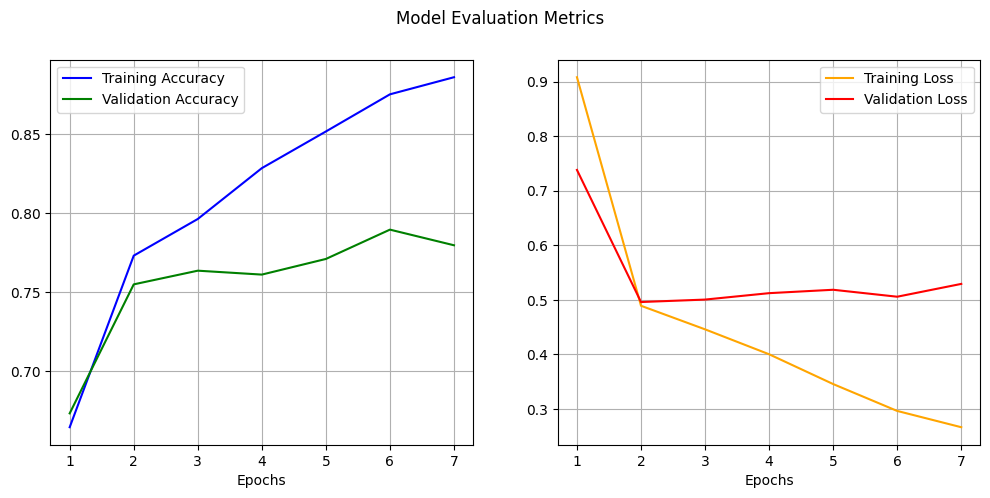

In [ ]:
othercnn = traindata(device, model_modified, num_epochs, optimizer, scheduler, criterion, train_loader, valid_loader, "cnn2_checkpoint.pth.tar")

In [ ]:
load_checkpoint(torch.load("/kaggle/working/cnn2_checkpoint.pth.tar"), model_modified, optimizer)

/tmp/ipykernel_30/2044460555.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_checkpoint(torch.load("/kaggle/working/cnn2_checkpoint.pth.tar"), model_modified, optim

Loading checkpoint


In [ ]:
df = test(device, model_modified, test_loader, criterion)
df=pd.concat([df, pd.DataFrame(test_labels["label"], columns=["true_label"])], axis=1)
df = df.dropna(subset=[0, 1, 2])
df["pred"]=df[[0, 1, 2]].idxmax(axis=1).astype(np.int64)
df.to_csv('cnn2.csv', index=False)
df

,0,1,2,true_label,pred
0,0.012481,0.343653,0.643866,0,2
1,0.000071,0.149453,0.850476,0,2
2,0.000037,0.085082,0.914882,0,2
3,0.933515,0.024497,0.041988,0,0
4,0.853183,0.104238,0.042579,0,0
...,...,...,...,...,...
525,0.004198,0.314027,0.681775,1,2
526,0.002771,0.301377,0.695852,1,2
527,0.164152,0.241323,0.594525,2,2
528,0.000193,0.590636,0.409171,1,1


In [ ]:
print("Test accuracy is: ", accuracy_score(df["true_label"], df["pred"]))

Test accuracy is:  0.3150943396226415


# Transformers

## From-scratch transformer

In [ ]:
import torch
import torch.nn as nn

class PatchEmbedding2(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super().__init__()
        self.num_patches = (img_size // patch_size) ** 2
        self.patch_size = patch_size
        self.embed_dim = embed_dim

        self.projection = nn.Conv2d(
            in_channels, embed_dim, kernel_size=patch_size, stride=patch_size
        )

    def forward(self, x):
        # Convert image to patch embeddings
        x = self.projection(x)  # [B, embed_dim, num_patches^(1/2), num_patches^(1/2)]
        x = x.flatten(2)  # [B, embed_dim, num_patches]
        x = x.transpose(1, 2)  # [B, num_patches, embed_dim]
        return x


class MultiHeadSelfAttention2(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "Embed_dim must be divisible by num_heads"

        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)

        self.dropout = nn.Dropout(dropout)
        self.proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, N, C = x.shape
        q = self.query(x).reshape(B, N, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.key(x).reshape(B, N, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.value(x).reshape(B, N, self.num_heads, self.head_dim).transpose(1, 2)

        scores = (q @ k.transpose(-2, -1)) * (1.0 / self.head_dim ** 0.5)
        attn = scores.softmax(dim=-1)
        attn = self.dropout(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        return x


class TransformerBlock2(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadSelfAttention2(embed_dim, num_heads, dropout)

        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, int(embed_dim * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(int(embed_dim * mlp_ratio), embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


class VisionTransformer2(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, num_classes=1000,
                 embed_dim=768, depth=12, num_heads=12, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbedding2(img_size, patch_size, in_channels, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + self.patch_embed.num_patches, embed_dim))
        self.dropout = nn.Dropout(dropout)

        self.blocks = nn.Sequential(
            *[TransformerBlock2(embed_dim, num_heads, mlp_ratio, dropout) for _ in range(depth)]
        )
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.dropout(x)

        x = self.blocks(x)
        x = self.norm(x)
        cls_token_final = x[:, 0]
        x = self.head(cls_token_final)
        return x

In [ ]:
model_t = VisionTransformer2(img_size=224, patch_size=16, num_classes=3).to(device)
optimizer = torch.optim.Adam(model_t.parameters(), lr=learning_rate)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=learning_rate * lr_ratio)
criterion = nn.CrossEntropyLoss()
checkpoint = {"state_dict": model_t.state_dict(), "optimizer": optimizer.state_dict(), "scheduler": scheduler}

1. epoch
Training accuracy: 0.33271434903144836 Training loss: 1.9773167325001137 
Validation accuracy: 0.30693069100379944 Validation loss: 1.1572223259852483
2. epoch
Training accuracy: 0.3225007951259613 Training loss: 1.1191600304023892 
Validation accuracy: 0.30693069100379944 Validation loss: 1.1048935743478627
3. epoch
Training accuracy: 0.3429279029369354 Training loss: 1.112688279619404 
Validation accuracy: 0.3589108884334564 Validation loss: 1.1037006378173828
4. epoch
Training accuracy: 0.33271434903144836 Training loss: 1.1083056622860479 
Validation accuracy: 0.33415842056274414 Validation loss: 1.1192414302092333
5. epoch
Training accuracy: 0.44103994965553284 Training loss: 1.0730364533031689 
Validation accuracy: 0.535891056060791 Validation loss: 0.9629222108767583
6. epoch
Training accuracy: 0.489631712436676 Training loss: 1.001346141684289 
Validation accuracy: 0.5792078971862793 Validation loss: 0.932543172286107
7. epoch
Training accuracy: 0.43949243426322937 Tra

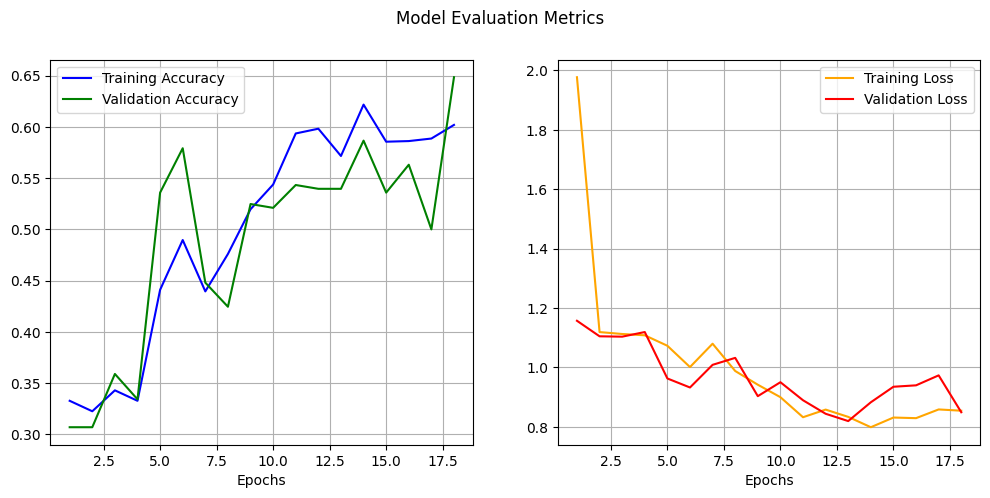

In [ ]:
trans2 = traindata(device, model_t, num_epochs, optimizer, scheduler, criterion, train_loader, valid_loader, "trans2_checkpoint.pth.tar")

In [ ]:
load_checkpoint(torch.load("/kaggle/working/trans2_checkpoint.pth.tar"), model_t, optimizer)

/tmp/ipykernel_30/2014299780.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_checkpoint(torch.load("/kaggle/working/trans2_checkpoint.pth.tar"), model_t, optimizer)

Loading checkpoint


In [ ]:
df = test(device, model_t, test_loader, criterion)
df=pd.concat([df, pd.DataFrame(test_labels["label"], columns=["true_label"])], axis=1)
df = df.dropna(subset=[0, 1, 2])
df["pred"]=df[[0, 1, 2]].idxmax(axis=1).astype(np.int64)
df.to_csv('trans2.csv', index=False)
df

,0,1,2,true_label,pred
0,0.480626,0.325960,0.193414,0,0
1,0.008711,0.511285,0.480005,0,1
2,0.010566,0.520426,0.469007,0,1
3,0.324956,0.421928,0.253116,0,1
4,0.782530,0.138427,0.079043,0,0
...,...,...,...,...,...
525,0.019409,0.531501,0.449090,1,1
526,0.035227,0.515548,0.449224,1,1
527,0.557505,0.287278,0.155217,2,0
528,0.017864,0.552343,0.429794,1,1


In [ ]:
print("Test accuracy is: ", accuracy_score(df["true_label"], df["pred"]))

Test accuracy is:  0.29056603773584905


## Pretrained transformer

In [ ]:
from timm import create_model

model_pt = create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)
model_pt = model_pt.to(device)
optimizer = optim.Adam(model_pt.parameters(), lr=learning_rate, weight_decay=weight_decay)
checkpoint = {"state_dict": model_pt.state_dict(), "optimizer": optimizer.state_dict(), "scheduler": scheduler}

1. epoch
Training accuracy: 0.3330238461494446 Training loss: 1.6773504439522238 
Validation accuracy: 0.36014851927757263 Validation loss: 1.0601877524302556
2. epoch
Training accuracy: 0.4407304525375366 Training loss: 1.0821431010377174 
Validation accuracy: 0.4554455280303955 Validation loss: 0.9661353001227746
3. epoch
Training accuracy: 0.5097493529319763 Training loss: 0.9671378427860784 
Validation accuracy: 0.4529702961444855 Validation loss: 0.990889874788431
4. epoch
Training accuracy: 0.560507595539093 Training loss: 0.8950883418905968 
Validation accuracy: 0.6410890817642212 Validation loss: 0.8044993785711435
5. epoch
Training accuracy: 0.621169924736023 Training loss: 0.8004033027910719 
Validation accuracy: 0.6806930303573608 Validation loss: 0.699754013465001
6. epoch
Training accuracy: 0.6394305229187012 Training loss: 0.7432115966198491 
Validation accuracy: 0.5457920432090759 Validation loss: 0.9214955522463872
7. epoch
Training accuracy: 0.6586196422576904 Training

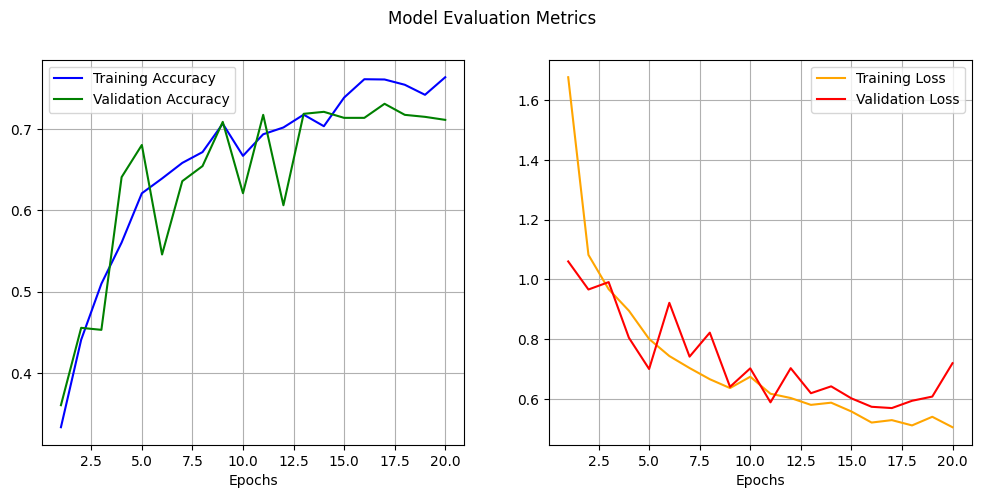

In [ ]:
pre_trans = traindata(device, model_pt, num_epochs, optimizer, scheduler, criterion, train_loader, valid_loader, "pretr_trans_checkpoint.pth.tar")

In [ ]:
load_checkpoint(torch.load("/kaggle/working/pretr_trans_checkpoint.pth.tar"), model_pt, optimizer)

/tmp/ipykernel_30/2106077422.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_checkpoint(torch.load("/kaggle/working/pretr_trans_checkpoint.pth.tar"), model_pt, opti

Loading checkpoint


In [ ]:
df = test(device, model_pt, test_loader, criterion)
df=pd.concat([df, pd.DataFrame(test_labels["label"], columns=["true_label"])], axis=1)
df = df.dropna(subset=[0, 1, 2])
df["pred"]=df[[0, 1, 2]].idxmax(axis=1).astype(np.int64)
df.to_csv('pretrans.csv', index=False)
df

,0,1,2,true_label,pred
0,0.014799,0.436017,0.549184,0,2
1,0.001538,0.223215,0.775247,0,2
2,0.000976,0.169915,0.829109,0,2
3,0.852763,0.090470,0.056767,0,0
4,0.507326,0.233884,0.258790,0,0
...,...,...,...,...,...
525,0.000495,0.237562,0.761943,1,2
526,0.003280,0.386732,0.609987,1,2
527,0.068735,0.678848,0.252417,2,1
528,0.005657,0.861669,0.132674,1,1


In [ ]:
print("Test accuracy is: ", accuracy_score(df["true_label"], df["pred"]))

Test accuracy is:  0.3320754716981132


# Pre-trained CNNs

In [ ]:
batch_size = 128

# Resnet

### With CosineAnnealingLR and fine tuning

In [ ]:
learning_rate = 1e-3
model_resnet_ = models.resnet50(pretrained=True)

for param in model_resnet_.parameters():
    param.requires_grad = False

model_resnet_.fc = nn.Linear(2048, num_classes)
model_resnet_ = model_resnet_.to(device=device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet_.parameters(), lr=learning_rate)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=learning_rate * lr_ratio)
checkpoint = {"state_dict": model_resnet_.state_dict(), "optimizer": optimizer.state_dict()}

resnet, [training_accuracy_list, training_loss_list, validation_accuracy_list, validation_loss_list] = traindata(device, model_resnet_, num_epochs, optimizer, scheduler, criterion, train_loader, valid_loader, "b_resnet_scheduler_checkpoint.pth.tar")

1. epoch
Training accuracy: 0.6381925344467163 Training loss: 0.8748022432510669 
Validation accuracy: 0.7376237511634827 Validation loss: 0.7543448039463588
2. epoch
Training accuracy: 0.7359950542449951 Training loss: 0.706637808909783 
Validation accuracy: 0.7252475023269653 Validation loss: 0.6071775470461164
3. epoch
Training accuracy: 0.7576602101325989 Training loss: 0.5944671676709101 
Validation accuracy: 0.7698019742965698 Validation loss: 0.5709120460918972
4. epoch
Training accuracy: 0.7623027563095093 Training loss: 0.568854774420078 
Validation accuracy: 0.7450494766235352 Validation loss: 0.549653559923172
5. epoch
Training accuracy: 0.7588981986045837 Training loss: 0.5559904781671671 
Validation accuracy: 0.7673267126083374 Validation loss: 0.5259891833577838
6. epoch
Training accuracy: 0.7691117525100708 Training loss: 0.5434123610074704 
Validation accuracy: 0.7660890817642212 Validation loss: 0.523265425648008
7. epoch
Training accuracy: 0.777158796787262 Training l

In [ ]:
for param in model_resnet_.parameters():
    param.requires_grad = True

resnet2, [training_accuracy_list2, training_loss_list2, validation_accuracy_list2, validation_loss_list2] = traindata(device, model_resnet_, 3, optimizer, scheduler, criterion, train_loader, valid_loader, "resnet_checkpoint_finetuned.pth.tar")

1. epoch
Training accuracy: 0.7474466562271118 Training loss: 0.5699292444265806 
Validation accuracy: 0.6287128329277039 Validation loss: 1.0393376009804862
2. epoch
Training accuracy: 0.8344166278839111 Training loss: 0.3796975589715518 
Validation accuracy: 0.7561880946159363 Validation loss: 0.4925544091633388
3. epoch
Training accuracy: 0.8337976336479187 Training loss: 0.3636062867366351 
Validation accuracy: 0.816831648349762 Validation loss: 0.39188135096005033


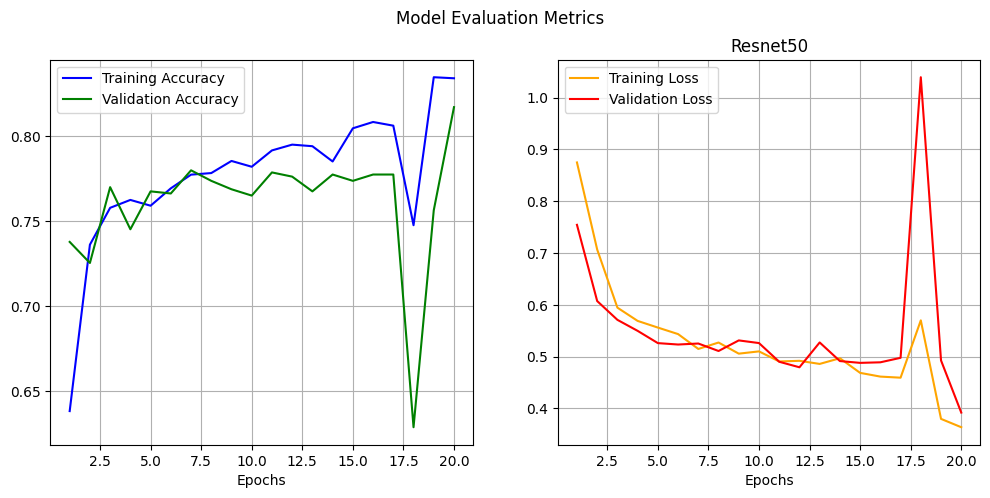

In [ ]:
plot_results(training_accuracy_list+training_accuracy_list2, training_loss_list+training_loss_list2, validation_accuracy_list+validation_accuracy_list2, validation_loss_list+validation_loss_list2, "Resnet50")

In [ ]:
load_checkpoint(torch.load("resnet_checkpoint_finetuned.pth.tar"), model_resnet_, optimizer)

Loading checkpoint


/tmp/ipykernel_30/1715561320.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_checkpoint(torch.load("resnet_checkpoint_finetuned.pth.tar"), model_resnet_, optimizer)

In [ ]:
df = test(device, resnet2, test_loader, criterion)
df=pd.concat([df, pd.DataFrame(test_labels["label"])], axis=1)
df["pred"]=df[[0, 1, 2]].idxmax(axis=1).astype(np.int64)
df.to_csv('resnet50_finetuned.csv', index=False)
df

,0,1,2,label,pred
0,2.866619e-03,0.797085,0.200048,0,1
1,6.646145e-01,0.313230,0.022155,0,0
2,9.998515e-01,0.000132,0.000016,0,0
3,9.990423e-01,0.000899,0.000059,0,0
4,7.978586e-04,0.513637,0.485565,0,1
...,...,...,...,...,...
619,1.466486e-04,0.243378,0.756476,2,2
620,9.220945e-08,0.158130,0.841870,2,2
621,1.949473e-04,0.404519,0.595287,1,2
622,2.967271e-07,0.795533,0.204467,1,1


In [ ]:
print("Test accuracy is: ", accuracy_score(df["label"], df["pred"]))

Test accuracy is:  0.8589743589743589


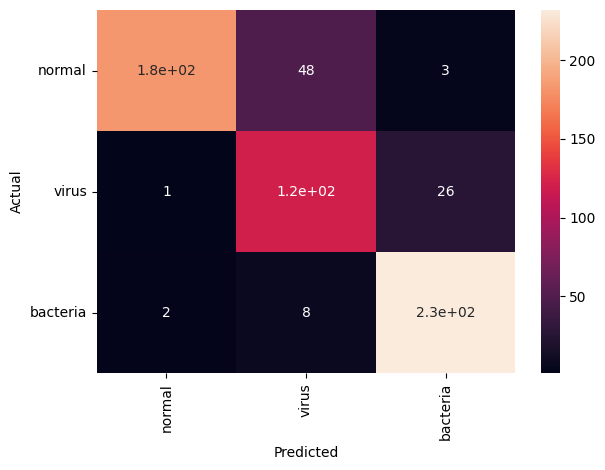

In [ ]:
conf_matrix = confusion_matrix(df["label"], df["pred"])
ax=sns.heatmap(conf_matrix, annot=True)
ax.set(xlabel="Predicted", ylabel="Actual")
ax.xaxis.set_ticklabels(["normal", "virus", "bacteria"], rotation=90)
ax.yaxis.set_ticklabels(["normal", "virus", "bacteria"], rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
learning_rate = 1e-3
weight_decay = 1e-4
model_resnet_ = models.resnet50(pretrained=True)

for param in model_resnet_.parameters():
    param.requires_grad = False

model_resnet_.fc = nn.Linear(2048, num_classes)
model_resnet_ = model_resnet_.to(device=device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_resnet_.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=learning_rate * lr_ratio)
checkpoint = {"state_dict": model_resnet_.state_dict(), "optimizer": optimizer.state_dict()}

resnet, [training_accuracy_list, training_loss_list, validation_accuracy_list, validation_loss_list] = traindata(device, model_resnet_, num_epochs, optimizer, scheduler, criterion, train_loader, valid_loader, "b_resnet_scheduler_checkpoint.pth.tar")



/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


1. epoch
Training accuracy: 0.5939338207244873 Training loss: 0.897003329717196 
Validation accuracy: 0.6237623691558838 Validation loss: 0.8476524523326329
2. epoch
Training accuracy: 0.7353760600090027 Training loss: 0.7251867995812342 
Validation accuracy: 0.7425742745399475 Validation loss: 0.6583589570862907
3. epoch
Training accuracy: 0.7585887312889099 Training loss: 0.598367840051651 
Validation accuracy: 0.7623762488365173 Validation loss: 0.5992762190955025
4. epoch
Training accuracy: 0.7567316889762878 Training loss: 0.5734151578866519 
Validation accuracy: 0.7537128329277039 Validation loss: 0.5915281772613525
5. epoch
Training accuracy: 0.7703498005867004 Training loss: 0.545665735235581 
Validation accuracy: 0.7574257254600525 Validation loss: 0.5651301997048515
6. epoch
Training accuracy: 0.7703498005867004 Training loss: 0.5387680553472959 
Validation accuracy: 0.7462871074676514 Validation loss: 0.5730919327054705
7. epoch
Training accuracy: 0.7678737640380859 Training

In [ ]:
load_checkpoint(torch.load("b_resnet_scheduler_checkpoint.pth.tar"), model_resnet_, optimizer)

Loading checkpoint


/tmp/ipykernel_30/2618835621.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_checkpoint(torch.load("b_resnet_scheduler_checkpoint.pth.tar"), model_resnet_, optimize

Fine tuning
1. epoch
Training accuracy: 0.7202104926109314 Training loss: 0.7129053679796366 
Validation accuracy: 0.3663366138935089 Validation loss: 38.020382744925364
2. epoch
Training accuracy: 0.8040854334831238 Training loss: 0.41227083595899433 
Validation accuracy: 0.7549504637718201 Validation loss: 0.6814217226845878
3. epoch
Training accuracy: 0.8180130124092102 Training loss: 0.3810540655484566 
Validation accuracy: 0.8155940175056458 Validation loss: 0.41771563036101206
4. epoch
Training accuracy: 0.8508202433586121 Training loss: 0.33912782829541427 
Validation accuracy: 0.6720296740531921 Validation loss: 0.8892203824860709
5. epoch
Training accuracy: 0.861343264579773 Training loss: 0.3043558339659984 
Validation accuracy: 0.7747524380683899 Validation loss: 0.4666819061551775


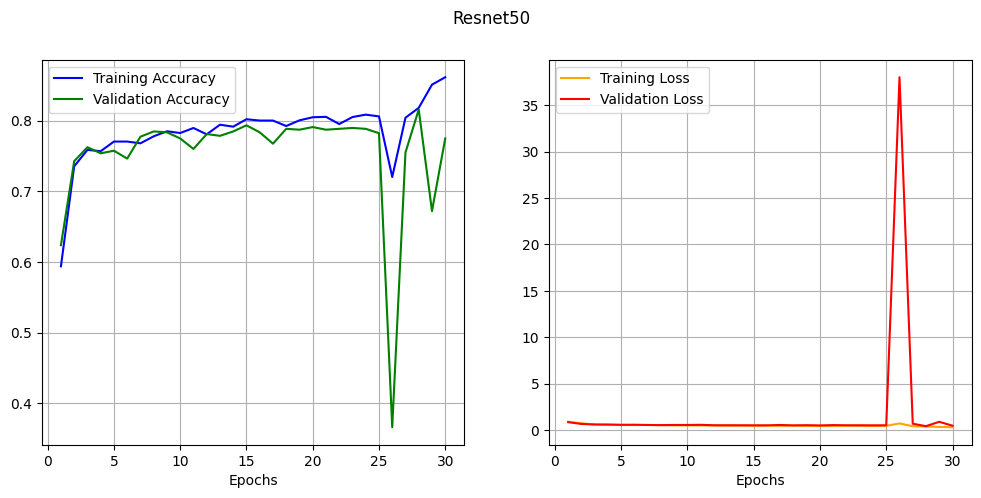

In [ ]:
print("Fine tuning")
for param in model_resnet_.parameters():
    param.requires_grad = True

scheduler=None
resnet2, [training_accuracy_list2, training_loss_list2, validation_accuracy_list2, validation_loss_list2] = traindata(device, model_resnet_, 5, optimizer, scheduler, criterion, train_loader, valid_loader, "resnet_checkpoint_finetuned.pth.tar")

plot_results(training_accuracy_list+training_accuracy_list2, training_loss_list+training_loss_list2, validation_accuracy_list+validation_accuracy_list2, validation_loss_list+validation_loss_list2, "Resnet50")

In [ ]:
load_checkpoint(torch.load("resnet_checkpoint_finetuned.pth.tar"), model_resnet_, optimizer)

Loading checkpoint


/tmp/ipykernel_30/1715561320.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_checkpoint(torch.load("resnet_checkpoint_finetuned.pth.tar"), model_resnet_, optimizer)

In [ ]:
df = test(device, resnet2, test_loader, criterion)
df=pd.concat([df, pd.DataFrame(test_labels["label"])], axis=1)
df["pred"]=df[[0, 1, 2]].idxmax(axis=1).astype(np.int64)
df.to_csv('resnet50_finetuned.csv', index=False)
df

,0,1,2,label,pred
0,9.774563e-03,0.504582,0.485644,0,1
1,3.794693e-02,0.891860,0.070193,0,1
2,9.989523e-01,0.000713,0.000335,0,0
3,7.240153e-01,0.258351,0.017634,0,0
4,1.749383e-03,0.106033,0.892217,0,2
...,...,...,...,...,...
619,7.318099e-03,0.355005,0.637677,2,2
620,3.417127e-06,0.064678,0.935318,2,2
621,1.859710e-04,0.816437,0.183377,1,1
622,1.166709e-04,0.684648,0.315235,1,1


In [ ]:
print("Test accuracy is: ", accuracy_score(df["label"], df["pred"]))

Test accuracy is:  0.7740384615384616


# VGG16

In [ ]:
# Load the VGG16 model
model_vgg = models.vgg16(pretrained=True)

# Freeze the parameters
for param in model_vgg.parameters():
    param.requires_grad = False

# Replace the last layer to match the number of classes
model_vgg.classifier[6] = nn.Linear(4096, num_classes)
model_vgg = model_vgg.to(device=device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_vgg.parameters(), lr=learning_rate)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=learning_rate * lr_ratio)
checkpoint = {"state_dict": model_vgg.state_dict(), "optimizer": optimizer.state_dict()}

vgg, [training_accuracy_list, training_loss_list, validation_accuracy_list, validation_loss_list] = traindata(device, model_vgg, num_epochs, optimizer, scheduler, criterion, train_loader, valid_loader, "vgg_checkpoint.pth.tar")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


1. epoch
Training accuracy: 0.6539771556854248 Training loss: 0.7959918838280898 
Validation accuracy: 0.712871253490448 Validation loss: 0.6856333357947213
2. epoch
Training accuracy: 0.716496467590332 Training loss: 0.6732038397055405 
Validation accuracy: 0.7450494766235352 Validation loss: 0.6229908977236066
3. epoch
Training accuracy: 0.7384710907936096 Training loss: 0.5982647354786212 
Validation accuracy: 0.7524752616882324 Validation loss: 0.5844593644142151
4. epoch
Training accuracy: 0.742185115814209 Training loss: 0.5962793276860163 
Validation accuracy: 0.7673267126083374 Validation loss: 0.5594285556248256
5. epoch
Training accuracy: 0.7582792043685913 Training loss: 0.5694349144513791 
Validation accuracy: 0.7611386179924011 Validation loss: 0.5547200994832175
6. epoch
Training accuracy: 0.7520891427993774 Training loss: 0.5652901793901737 
Validation accuracy: 0.7673267126083374 Validation loss: 0.5579680459839957
7. epoch
Training accuracy: 0.7650882601737976 Training

In [ ]:
# finetuning
for param in model_vgg.parameters():
    param.requires_grad = True

vgg2, [training_accuracy_list2, training_loss_list2, validation_accuracy_list2, validation_loss_list2] = traindata(device, model_vgg, 3, optimizer, scheduler, criterion, train_loader, valid_loader, "vgg_checkpoint_finetuned.pth.tar")

1. epoch
Training accuracy: 0.49736925959587097 Training loss: 1.3783384011341975 
Validation accuracy: 0.6175742745399475 Validation loss: 0.7161887884140015
2. epoch
Training accuracy: 0.37697309255599976 Training loss: 1.953912778542592 
Validation accuracy: 0.31806930899620056 Validation loss: 1.0709999629429408
3. epoch
Training accuracy: 0.4552770256996155 Training loss: 1.0054166408685536 
Validation accuracy: 0.38118812441825867 Validation loss: 1.0178287880761283


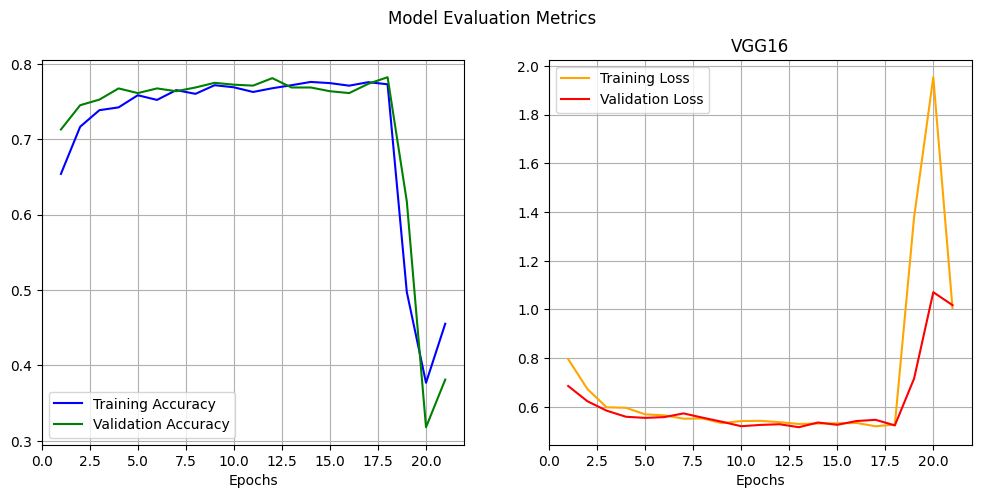

In [ ]:
plot_results(training_accuracy_list+training_accuracy_list2, training_loss_list+training_loss_list2, validation_accuracy_list+validation_accuracy_list2, validation_loss_list+validation_loss_list2, "VGG16")

In [ ]:
load_checkpoint(torch.load("vgg_checkpoint_finetuned.pth.tar"), model_vgg, optimizer)

/tmp/ipykernel_30/2415708443.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_checkpoint(torch.load("vgg_checkpoint_finetuned.pth.tar"), model_vgg, optimizer)


Loading checkpoint


In [ ]:
df = test(device, vgg2, test_loader, criterion)
df=pd.concat([df, pd.DataFrame(test_labels["label"])], axis=1)
df["pred"]=df[[0, 1, 2]].idxmax(axis=1).astype(np.int64)
df.to_csv('vgg_finetuned.csv', index=False)
df

,0,1,2,label,pred
0,0.542187,0.246718,0.211095,0,0
1,0.425088,0.328839,0.246074,0,0
2,0.980084,0.009845,0.010071,0,0
3,0.531233,0.251449,0.217318,0,0
4,0.694227,0.165020,0.140753,0,0
...,...,...,...,...,...
619,0.019680,0.465870,0.514450,2,2
620,0.005707,0.422999,0.571294,2,2
621,0.096403,0.477232,0.426365,1,1
622,0.024839,0.458491,0.516670,1,2


In [ ]:
print("Test accuracy is: ", accuracy_score(df["label"], df["pred"]))

Test accuracy is:  0.6858974358974359


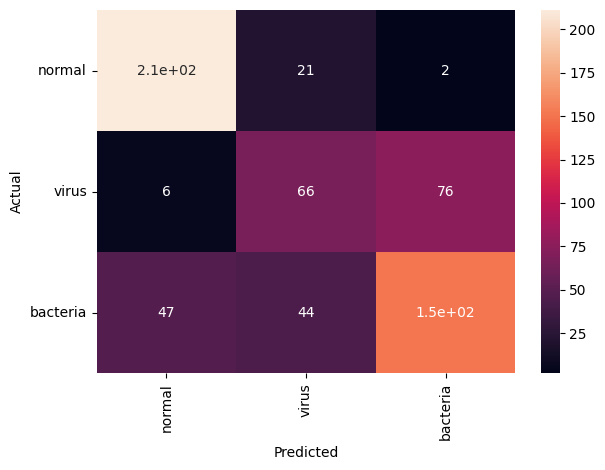

In [ ]:
conf_matrix = confusion_matrix(df["label"], df["pred"])
ax=sns.heatmap(conf_matrix, annot=True)
ax.set(xlabel="Predicted", ylabel="Actual")
ax.xaxis.set_ticklabels(["normal", "virus", "bacteria"], rotation=90)
ax.yaxis.set_ticklabels(["normal", "virus", "bacteria"], rotation=0)
plt.tight_layout()
plt.show()

# EfficientNetB0

In [ ]:
# Load the EfficientNet-B0 model
model_efficientnet = models.efficientnet_b0(pretrained=True)

# Freeze the parameters
for param in model_efficientnet.parameters():
    param.requires_grad = False

# Replace the classifier to match the number of classes
model_efficientnet.classifier[1] = nn.Linear(model_efficientnet.classifier[1].in_features, num_classes)

# Move the model to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_efficientnet = model_efficientnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_efficientnet.parameters(), lr=learning_rate)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=learning_rate * lr_ratio)
checkpoint = {"state_dict": model_efficientnet.state_dict(), "optimizer": optimizer.state_dict(), "scheduler": scheduler}

model_eff, [training_accuracy_list, training_loss_list, validation_accuracy_list, validation_loss_list] = traindata(device, model_efficientnet, num_epochs, optimizer, scheduler, criterion, train_loader, valid_loader, "effnet_checkpoint_2.pth.tar")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 130MB/s] 


1. epoch
Training accuracy: 0.6521201133728027 Training loss: 0.8704667183069082 
Validation accuracy: 0.691831648349762 Validation loss: 0.8186491472380502
2. epoch
Training accuracy: 0.7174249887466431 Training loss: 0.754879715350958 
Validation accuracy: 0.6930692791938782 Validation loss: 0.7445662702832904
3. epoch
Training accuracy: 0.7465181350708008 Training loss: 0.6451875154788678 
Validation accuracy: 0.7475247383117676 Validation loss: 0.6329793078558785
4. epoch
Training accuracy: 0.7536366581916809 Training loss: 0.6242759915498587 
Validation accuracy: 0.7586633563041687 Validation loss: 0.5690220849854606
5. epoch
Training accuracy: 0.7567316889762878 Training loss: 0.5910507096694066 
Validation accuracy: 0.7660890817642212 Validation loss: 0.5892685311181205
6. epoch
Training accuracy: 0.7629217505455017 Training loss: 0.5761793244343537 
Validation accuracy: 0.7735148668289185 Validation loss: 0.5315445278372083
7. epoch
Training accuracy: 0.7706592679023743 Trainin

In [ ]:
# fine tuning
for param in model_efficientnet.parameters():
    param.requires_grad = True

model_eff2, [training_accuracy_list2, training_loss_list2, validation_accuracy_list2, validation_loss_list2] = traindata(device, model_efficientnet, 3, optimizer, scheduler, criterion, train_loader, valid_loader, "effnet_checkpoint_finetuned.pth.tar")

1. epoch
Training accuracy: 0.7700402736663818 Training loss: 0.4968300828566918 
Validation accuracy: 0.8155940175056458 Validation loss: 0.3909976269517626
2. epoch
Training accuracy: 0.8783658742904663 Training loss: 0.30896370800641865 
Validation accuracy: 0.823019802570343 Validation loss: 0.4079498989241464
3. epoch
Training accuracy: 0.9179821014404297 Training loss: 0.2105605934674923 
Validation accuracy: 0.8366336226463318 Validation loss: 0.4076027955327715


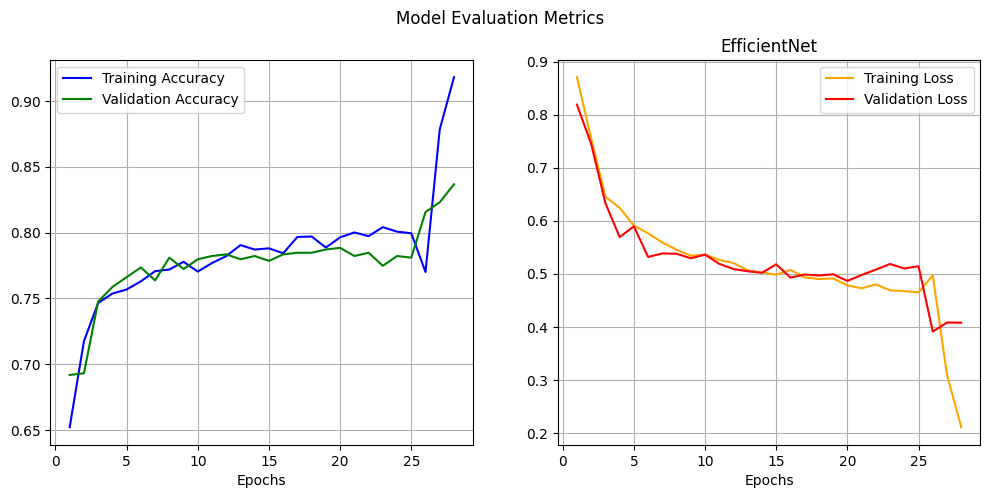

In [ ]:
plot_results(training_accuracy_list+training_accuracy_list2, training_loss_list+training_loss_list2, validation_accuracy_list+validation_accuracy_list2, validation_loss_list+validation_loss_list2, "EfficientNet")

In [ ]:
load_checkpoint(torch.load("effnet_checkpoint_finetuned.pth.tar"), model_efficientnet, optimizer)

Loading checkpoint


/tmp/ipykernel_30/1987248005.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_checkpoint(torch.load("effnet_checkpoint_finetuned.pth.tar"), model_efficientnet, optim

In [ ]:
df = test(device, model_eff2, test_loader, criterion)
df=pd.concat([df, pd.DataFrame(test_labels["label"])], axis=1)
df["pred"]=df[[0, 1, 2]].idxmax(axis=1).astype(np.int64)
df.to_csv('efficientnet_finetuned.csv', index=False)
df

,0,1,2,label,pred
0,0.011259,0.755914,0.232828,0,1
1,0.003220,0.885541,0.111239,0,1
2,0.999995,0.000002,0.000003,0,0
3,0.997048,0.002662,0.000289,0,0
4,0.021889,0.611101,0.367010,0,1
...,...,...,...,...,...
619,0.025540,0.424306,0.550154,2,2
620,0.013754,0.572389,0.413857,2,1
621,0.000299,0.959696,0.040004,1,1
622,0.007069,0.827195,0.165735,1,1


In [ ]:
print("Test accuracy is: ", accuracy_score(df["label"], df["pred"]))

Test accuracy is:  0.8189102564102564


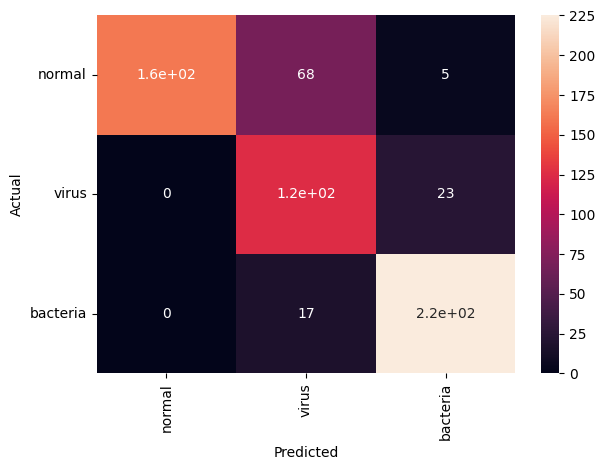

In [ ]:
conf_matrix = confusion_matrix(df["label"], df["pred"])
ax=sns.heatmap(conf_matrix, annot=True)
ax.set(xlabel="Predicted", ylabel="Actual")
ax.xaxis.set_ticklabels(["normal", "virus", "bacteria"], rotation=90)
ax.yaxis.set_ticklabels(["normal", "virus", "bacteria"], rotation=0)
plt.tight_layout()
plt.show()

### using AdamW

In [ ]:
# Load the EfficientNet-B0 model
model_efficientnet = models.efficientnet_b0(pretrained=True)

# Freeze the parameters
for param in model_efficientnet.parameters():
    param.requires_grad = False

# Replace the classifier to match the number of classes
model_efficientnet.classifier[1] = nn.Linear(model_efficientnet.classifier[1].in_features, num_classes)

# Move the model to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_efficientnet = model_efficientnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_efficientnet.parameters(), lr=learning_rate, weight_decay = weight_decay)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=learning_rate * lr_ratio)
checkpoint = {"state_dict": model_efficientnet.state_dict(), "optimizer": optimizer.state_dict(), "scheduler": scheduler}

model_eff, [training_accuracy_list, training_loss_list, validation_accuracy_list, validation_loss_list] = traindata(device, model_efficientnet, num_epochs, optimizer, scheduler, criterion, train_loader, valid_loader, "effnet_checkpoint_2.pth.tar")

1. epoch
Training accuracy: 0.6474775671958923 Training loss: 0.8843810351995322 
Validation accuracy: 0.6621286869049072 Validation loss: 0.8755771177155631
2. epoch
Training accuracy: 0.7242340445518494 Training loss: 0.7668245824483725 
Validation accuracy: 0.6831682920455933 Validation loss: 0.8002023441450936
3. epoch
Training accuracy: 0.7418755888938904 Training loss: 0.6487711507540482 
Validation accuracy: 0.7450494766235352 Validation loss: 0.6565706304141453
4. epoch
Training accuracy: 0.7418755888938904 Training loss: 0.6295136305002066 
Validation accuracy: 0.7524752616882324 Validation loss: 0.5975646036011832
5. epoch
Training accuracy: 0.741256594657898 Training loss: 0.5878514051437378 
Validation accuracy: 0.7561880946159363 Validation loss: 0.6057997175625393
6. epoch
Training accuracy: 0.752398669719696 Training loss: 0.57927217735694 
Validation accuracy: 0.7673267126083374 Validation loss: 0.5667809077671596
7. epoch
Training accuracy: 0.7709687948226929 Training 

In [ ]:
load_checkpoint(torch.load("effnet_checkpoint_2.pth.tar"), model_efficientnet, optimizer)

Loading checkpoint


/tmp/ipykernel_30/1553077526.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_checkpoint(torch.load("effnet_checkpoint_2.pth.tar"), model_efficientnet, optimizer)


In [ ]:
# fine tuning
for param in model_efficientnet.parameters():
    param.requires_grad = True


model_eff2, [training_accuracy_list2, training_loss_list2, validation_accuracy_list2, validation_loss_list2] = traindata(device, model_efficientnet, 5, optimizer, scheduler, criterion, train_loader, valid_loader, "effnet_checkpoint_finetuned.pth.tar")

1. epoch
Training accuracy: 0.7783968448638916 Training loss: 0.4881465652814278 
Validation accuracy: 0.7920792102813721 Validation loss: 0.4931263668196542
2. epoch
Training accuracy: 0.8721758127212524 Training loss: 0.3051405872863073 
Validation accuracy: 0.7945544719696045 Validation loss: 0.4943914839199611
3. epoch
Training accuracy: 0.9127205610275269 Training loss: 0.20806856453418732 
Validation accuracy: 0.844059407711029 Validation loss: 0.4562272642339979
4. epoch
Training accuracy: 0.9554318189620972 Training loss: 0.11819716342366658 
Validation accuracy: 0.8217821717262268 Validation loss: 0.5153731022562299
5. epoch
Training accuracy: 0.9554318189620972 Training loss: 0.12899396941065788 
Validation accuracy: 0.8143564462661743 Validation loss: 0.560886664049966


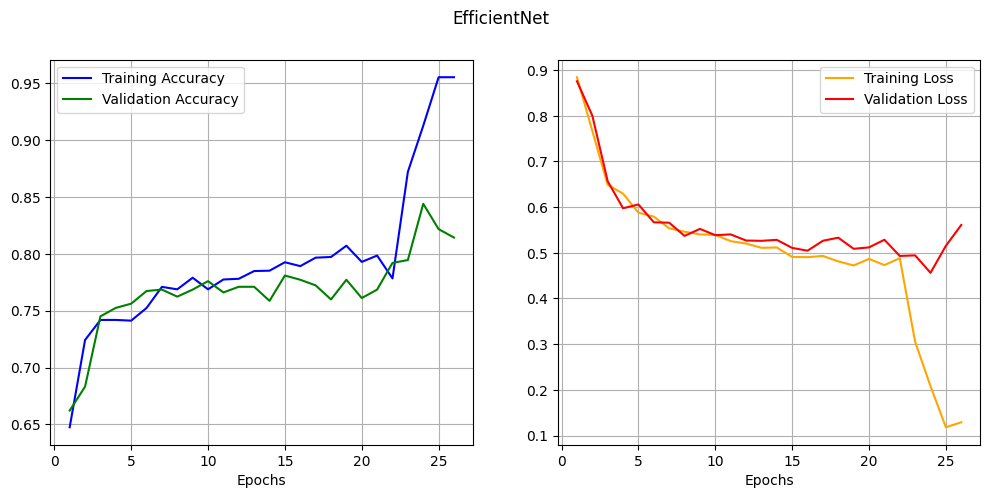

In [ ]:
plot_results(training_accuracy_list+training_accuracy_list2, training_loss_list+training_loss_list2, validation_accuracy_list+validation_accuracy_list2, validation_loss_list+validation_loss_list2, "EfficientNet")

In [ ]:
load_checkpoint(torch.load("effnet_checkpoint_finetuned.pth.tar"), model_efficientnet, optimizer)

Loading checkpoint


/tmp/ipykernel_30/1987248005.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_checkpoint(torch.load("effnet_checkpoint_finetuned.pth.tar"), model_efficientnet, optim

In [ ]:
df = test(device, model_eff2, test_loader, criterion)
df=pd.concat([df, pd.DataFrame(test_labels["label"])], axis=1)
df["pred"]=df[[0, 1, 2]].idxmax(axis=1).astype(np.int64)
df.to_csv('efficientnet_finetuned.csv', index=False)
df

,0,1,2,label,pred
0,0.014419,9.406720e-01,4.490874e-02,0,1
1,0.019451,9.657777e-01,1.477101e-02,0,1
2,1.000000,6.291963e-08,5.810519e-08,0,0
3,0.999968,3.108469e-05,7.773370e-07,0,0
4,0.019111,9.375558e-01,4.333271e-02,0,1
...,...,...,...,...,...
619,0.000002,4.086383e-02,9.591345e-01,2,2
620,0.000006,4.380872e-02,9.561851e-01,2,2
621,0.000052,9.859785e-01,1.396993e-02,1,1
622,0.000012,9.954258e-01,4.561913e-03,1,1


In [ ]:
print("Test accuracy is: ", accuracy_score(df["label"], df["pred"]))

Test accuracy is:  0.8333333333333334


In [ ]:
weight_decay = 5*1e-4

# Load the EfficientNet-B0 model
model_efficientnet = models.efficientnet_b0(pretrained=True)

# Freeze the parameters
for param in model_efficientnet.parameters():
    param.requires_grad = False

# Replace the classifier to match the number of classes
model_efficientnet.classifier[1] = nn.Linear(model_efficientnet.classifier[1].in_features, num_classes)

# Move the model to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_efficientnet = model_efficientnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_efficientnet.parameters(), lr=learning_rate, weight_decay = weight_decay)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=learning_rate * lr_ratio)
checkpoint = {"state_dict": model_efficientnet.state_dict(), "optimizer": optimizer.state_dict(), "scheduler": scheduler}

model_eff, [training_accuracy_list, training_loss_list, validation_accuracy_list, validation_loss_list] = traindata(device, model_efficientnet, num_epochs, optimizer, scheduler, criterion, train_loader, valid_loader, "effnet_checkpoint_2.pth.tar")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


1. epoch
Training accuracy: 0.6292169690132141 Training loss: 0.8997951677212348 
Validation accuracy: 0.6670792102813721 Validation loss: 0.8823589171682086
2. epoch
Training accuracy: 0.7189725041389465 Training loss: 0.7657546561497909 
Validation accuracy: 0.6633663177490234 Validation loss: 0.7901371376855033
3. epoch
Training accuracy: 0.738161563873291 Training loss: 0.6571615842672495 
Validation accuracy: 0.7240098714828491 Validation loss: 0.6551523293767657
4. epoch
Training accuracy: 0.7440420985221863 Training loss: 0.626413854268881 
Validation accuracy: 0.7462871074676514 Validation loss: 0.589069242988314
5. epoch
Training accuracy: 0.7486846446990967 Training loss: 0.5991571843624115 
Validation accuracy: 0.7400990128517151 Validation loss: 0.583042962210519
6. epoch
Training accuracy: 0.7517796754837036 Training loss: 0.5827149771727048 
Validation accuracy: 0.7574257254600525 Validation loss: 0.5785247768674578
7. epoch
Training accuracy: 0.7613742351531982 Training 

In [ ]:
load_checkpoint(torch.load("effnet_checkpoint_2.pth.tar"), model_efficientnet, optimizer)

Loading checkpoint


/tmp/ipykernel_30/1553077526.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_checkpoint(torch.load("effnet_checkpoint_2.pth.tar"), model_efficientnet, optimizer)


1. epoch
Training accuracy: 0.7898483872413635 Training loss: 0.4852028019153155 
Validation accuracy: 0.8131188154220581 Validation loss: 0.496606068951743
2. epoch
Training accuracy: 0.8628907799720764 Training loss: 0.3276462738330548 
Validation accuracy: 0.8254950642585754 Validation loss: 0.4249056279659271
3. epoch
Training accuracy: 0.9124110341072083 Training loss: 0.21194319484325555 
Validation accuracy: 0.8415841460227966 Validation loss: 0.47800000650542124
4. epoch
Training accuracy: 0.942432701587677 Training loss: 0.1429566444399265 
Validation accuracy: 0.8341584205627441 Validation loss: 0.510968450989042
5. epoch
Training accuracy: 0.9588363170623779 Training loss: 0.11329569108784199 
Validation accuracy: 0.8007425665855408 Validation loss: 0.8444560425622123


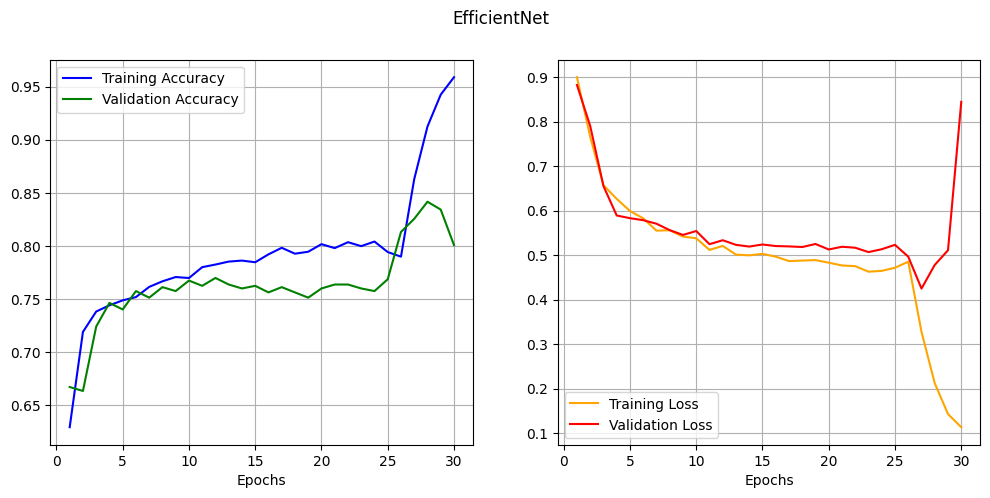

In [ ]:
# fine tuning
for param in model_efficientnet.parameters():
    param.requires_grad = True
scheduler = None#CosineAnnealingLR(optimizer, T_max=5, eta_min=learning_rate * lr_ratio)
model_eff2, [training_accuracy_list2, training_loss_list2, validation_accuracy_list2, validation_loss_list2] = traindata(device, model_efficientnet, 5, optimizer, scheduler, criterion, train_loader, valid_loader, "effnet_checkpoint_finetuned.pth.tar")
plot_results(training_accuracy_list+training_accuracy_list2, training_loss_list+training_loss_list2, validation_accuracy_list+validation_accuracy_list2, validation_loss_list+validation_loss_list2, "EfficientNet")

In [ ]:
load_checkpoint(torch.load("effnet_checkpoint_finetuned.pth.tar"), model_efficientnet, optimizer)

Loading checkpoint


/tmp/ipykernel_30/1987248005.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_checkpoint(torch.load("effnet_checkpoint_finetuned.pth.tar"), model_efficientnet, optim

In [ ]:
df = test(device, model_eff2, test_loader, criterion)
df=pd.concat([df, pd.DataFrame(test_labels["label"])], axis=1)
df["pred"]=df[[0, 1, 2]].idxmax(axis=1).astype(np.int64)
df.to_csv('efficientnet_finetuned.csv', index=False)
df

,0,1,2,label,pred
0,2.735546e-03,0.734143,2.631209e-01,0,1
1,1.540554e-01,0.755470,9.047472e-02,0,1
2,9.999944e-01,0.000004,1.567672e-06,0,0
3,9.999967e-01,0.000003,2.798464e-07,0,0
4,5.350315e-05,0.185932,8.140149e-01,0,2
...,...,...,...,...,...
619,2.122504e-03,0.115246,8.826311e-01,2,2
620,1.823614e-06,0.144358,8.556404e-01,2,2
621,1.019622e-03,0.661525,3.374549e-01,1,1
622,5.075152e-08,0.999100,9.003587e-04,1,1


In [ ]:
print("Test accuracy is: ", accuracy_score(df["label"], df["pred"]))

Test accuracy is:  0.8830128205128205


This is the best test accuracy we have.

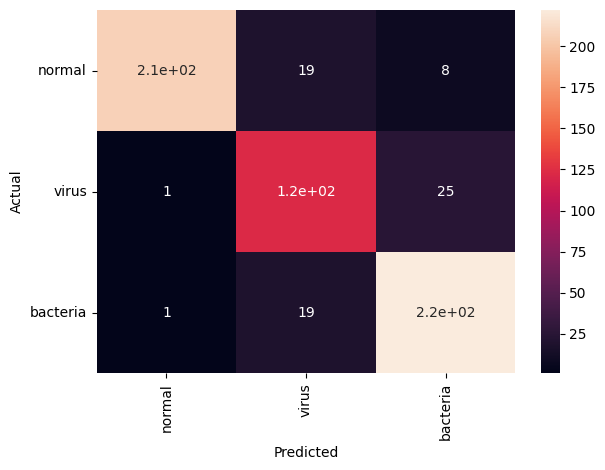

In [ ]:
conf_matrix = confusion_matrix(df["label"], df["pred"])
ax=sns.heatmap(conf_matrix, annot=True)
ax.set(xlabel="Predicted", ylabel="Actual")
ax.xaxis.set_ticklabels(["normal", "virus", "bacteria"], rotation=90)
ax.yaxis.set_ticklabels(["normal", "virus", "bacteria"], rotation=0)
plt.tight_layout()
plt.show()

# MobileNetV2

In [ ]:
# Load the MobileNetV2 model
model_mobilenet = models.mobilenet_v2(pretrained=True)

# Freeze the parameters
for param in model_mobilenet.parameters():
    param.requires_grad = False

# Replace the classifier to match the number of classes
model_mobilenet.classifier[1] = nn.Linear(model_mobilenet.last_channel, num_classes)

# Move the model to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_mobilenet = model_mobilenet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mobilenet.parameters(), lr=learning_rate)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=learning_rate * lr_ratio)
checkpoint = {"state_dict": model_mobilenet.state_dict(), "optimizer": optimizer.state_dict(), "scheduler": scheduler}

model_mob, [training_accuracy_list, training_loss_list, validation_accuracy_list, validation_loss_list] = traindata(device, model_mobilenet, num_epochs, optimizer, scheduler, criterion, train_loader, valid_loader, "mobnet_checkpoint.pth.tar")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 126MB/s]


1. epoch
Training accuracy: 0.6375735402107239 Training loss: 0.8207607269287109 
Validation accuracy: 0.5990098714828491 Validation loss: 0.8126232198306492
2. epoch
Training accuracy: 0.7099969387054443 Training loss: 0.6952079832553864 
Validation accuracy: 0.6707920432090759 Validation loss: 0.6688475012779236
3. epoch
Training accuracy: 0.7437326312065125 Training loss: 0.6050113714658297 
Validation accuracy: 0.7462871074676514 Validation loss: 0.5742631810052055
4. epoch
Training accuracy: 0.755493700504303 Training loss: 0.582575491987742 
Validation accuracy: 0.7561880946159363 Validation loss: 0.5459104989256177
5. epoch
Training accuracy: 0.7629217505455017 Training loss: 0.5621137309532899 
Validation accuracy: 0.764851450920105 Validation loss: 0.5362721724169595
6. epoch
Training accuracy: 0.7669452428817749 Training loss: 0.5482815721860299 
Validation accuracy: 0.7561880946159363 Validation loss: 0.547025488955634
7. epoch
Training accuracy: 0.7833488583564758 Training 

In [ ]:
# fine tuning
for param in model_mobilenet.parameters():
    param.requires_grad = True

model_mob2, [training_accuracy_list2, training_loss_list2, validation_accuracy_list2, validation_loss_list2] = traindata(device, model_mobilenet, 3, optimizer, scheduler, criterion, train_loader, valid_loader, "mobnet_checkpoint_finetuned.pth.tar")

1. epoch
Training accuracy: 0.7827298641204834 Training loss: 0.5086496552595725 
Validation accuracy: 0.8155940175056458 Validation loss: 0.4219762214592525
2. epoch
Training accuracy: 0.8437016606330872 Training loss: 0.37251210785829103 
Validation accuracy: 0.7908415794372559 Validation loss: 0.4213495595114572
3. epoch
Training accuracy: 0.861343264579773 Training loss: 0.335308391887408 
Validation accuracy: 0.8155940175056458 Validation loss: 0.4194647627217429


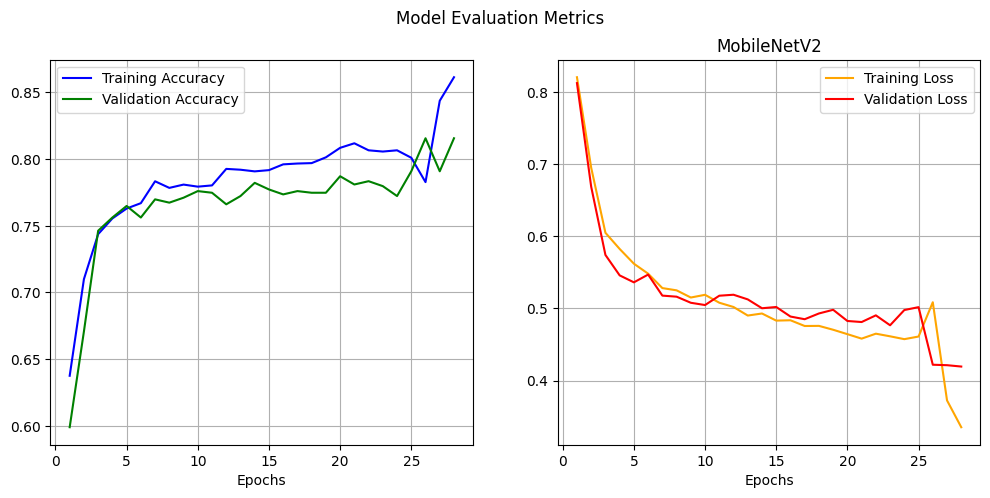

In [ ]:
plot_results(training_accuracy_list+training_accuracy_list2, training_loss_list+training_loss_list2, validation_accuracy_list+validation_accuracy_list2, validation_loss_list+validation_loss_list2, "MobileNetV2")

In [ ]:
load_checkpoint(torch.load("mobnet_checkpoint_finetuned.pth.tar"), model_mobilenet, optimizer)

Loading checkpoint


/tmp/ipykernel_30/1158555411.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_checkpoint(torch.load("mobnet_checkpoint_finetuned.pth.tar"), model_mobilenet, optimize

In [ ]:
df = test(device, model_mob2, test_loader, criterion)
df=pd.concat([df, pd.DataFrame(test_labels["label"])], axis=1)
df["pred"]=df[[0, 1, 2]].idxmax(axis=1).astype(np.int64)
df.to_csv('mobilenet_finetuned.csv', index=False)
df

,0,1,2,label,pred
0,6.241170e-05,0.261821,0.738117,0,2
1,9.159427e-01,0.079404,0.004654,0,0
2,9.999759e-01,0.000005,0.000019,0,0
3,7.797911e-01,0.184306,0.035903,0,0
4,6.865762e-05,0.182164,0.817767,0,2
...,...,...,...,...,...
619,1.323092e-04,0.039064,0.960803,2,2
620,5.529440e-09,0.022686,0.977314,2,2
621,2.582749e-06,0.651226,0.348771,1,1
622,5.509341e-06,0.845384,0.154611,1,1


In [ ]:
print("Test accuracy is: ", accuracy_score(df["label"], df["pred"]))

Test accuracy is:  0.7964743589743589


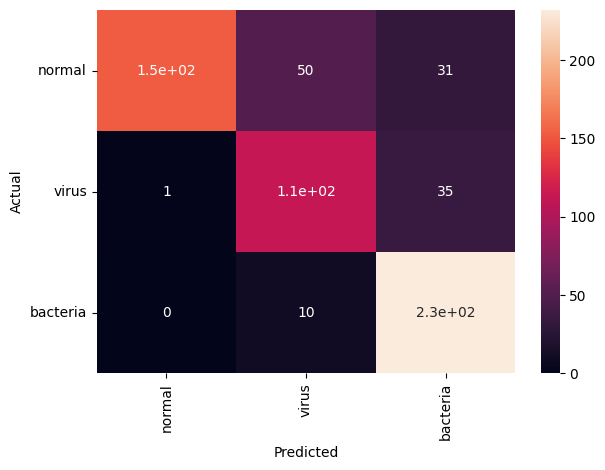

In [ ]:
conf_matrix = confusion_matrix(df["label"], df["pred"])
ax=sns.heatmap(conf_matrix, annot=True)
ax.set(xlabel="Predicted", ylabel="Actual")
ax.xaxis.set_ticklabels(["normal", "virus", "bacteria"], rotation=90)
ax.yaxis.set_ticklabels(["normal", "virus", "bacteria"], rotation=0)
plt.tight_layout()
plt.show()